# Al Nuclear Excited States

An Ipython notebook for fitting experimentally extracted form factors from the electroexcitation of Al nuclear excited states.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns
from scipy.optimize import curve_fit

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
%matplotlib inline

In [3]:
pp.style.use('seaborn-ticks')
sns.set_palette("muted")
plot_size = 6*np.array([1.0,(2.0/(1.0+np.sqrt(5.0)))]) #Use Golden ratio as aspect ratio for plots

In [41]:
# Plot range ranges
x_low = 0.5 # [1/fm]
x_high = 2.5 # [1/fm]
y_low = 1e-6
y_high = 1e-2

fit_x_range = np.linspace(x_low,x_high,1e3)

qweak_acceptance = (0.676, 1.188)# Qweak Q acceptance [1/fm]

#fit_range = (0.5, 1.4) # [1/fm]
fit_range = (0.5, 1.8) # [1/fm]
#fit_range = qweak_acceptance

energy_lvl = ('0.844', 
              '1.0140',
              '2.2110',
              '2.7350',
              '2.9900',
              '3.6800',
              '3.9570',
              '4.0550',
              '4.4100',
              '4.5100',
              '4.5800',
              '4.8120',
              '5.1560',
              '5.2480',
              '5.4300',
              '5.5000',
              '5.5510',
              '5.6680',
              '5.8270',
              '5.9600',
              '6.1600',
              '6.4770',
              '6.5200',
              '6.6050',
              '6.6515',
              '6.7100',
              '6.9480',
              '7.2280',
              '7.2900',
              '7.4100',
              '7.4770',
              '7.5800',
              '7.6600',
              '7.8000',
              '8.4000',
              '8.5200',
              '8.8200')

In [42]:
# Define functions
def gaussian(x, const, mu, sigma):
    'Gaussian Fit Function'
    numerator = -1.0*np.square(x-mu)
    denominator = 2.0*np.square(sigma)
    return const * np.exp(numerator/denominator)

def gaussian_err(x, pcov, const, mu, sigma):
    'Error Function for Gaussian Fit'
    
    # Calculate partials
    df_dc = gaussian(x, 1.0, mu, sigma)
    df_dmu = ((const*(x-mu))/(sigma*sigma))*gaussian(x, 1.0, mu, sigma)
    df_dsig = ((const*np.square(x-mu))/(sigma*sigma*sigma))*gaussian(x, 1.0, mu, sigma)
    
    const_term = pcov[0,0]*df_dc*df_dc
    mu_term = pcov[1,1]*df_dmu*df_dmu
    sigma_term = pcov[2,2]*df_dsig*df_dsig
    c_mu_term = 2.0*pcov[0,1]*df_dc*df_dmu
    c_sigma_term = 2.0*pcov[0,2]*df_dc*df_dsig
    mu_sigma_term = 2.0*pcov[1,2]*df_dmu*df_dsig

    return np.sqrt(const_term + mu_term + sigma_term + c_mu_term + c_sigma_term + mu_sigma_term)

def print_fit_info(popt, pcov, chi2, dof):
    'Print Fit Parameters'
    string = 'Constant: {0:.3e} +- {1:.3e} \n\
    Mean: {2:.7f} +- {3:.7f} \n\
    Sigma: {4:.7f} +- {5:.7f} \n\
    Chi**2: {6:.3f} \n\
    DOF: {7:d} \n\
    RChi**2: {8:.3f}'.format(popt[0], 
                           np.sqrt(pcov[0,0]),
                           popt[1], 
                           np.sqrt(pcov[1,1]), 
                           popt[2], 
                           np.sqrt(pcov[2,2]), 
                           chi2, 
                           dof, 
                           chi2/dof)
    return print(string)

def pdiff(data,fit):
    return 100.0*(data - fit)/data

def pdiff_err(data, data_err, fit, fit_err):
    df_ddata = (100.0*fit)/(data*data)
    df_dfit = -100.0/data
    
    data_term = data_err*data_err*df_ddata*df_ddata
    fit_term = fit_err*fit_err*df_dfit*df_dfit
    return np.sqrt(data_term + fit_term)

def chi2(x,y,y_err,popt):
    return np.sum(np.square((y-gaussian(x, *popt))/y_err))

def Q_eff_angle_cut(data):
    return data.Q_eff[(data.theta < 160.0)]

def FF_angle_cut(data):
    return data.f_total_sq[(data.theta < 160.0)]

def Err_angle_cut(data):
    return data.xsection_err[(data.theta < 160.0)]

def Q_eff_fit_cut(data, low, high):
    return data.Q_eff[(data.theta < 160.0) & (data.Q_eff > low) & (data.Q_eff < high)]

def FF_fit_cut(data, low, high):
    return data.f_total_sq[(data.theta < 160.0) & (data.Q_eff > low) & (data.Q_eff < high)]

def Err_fit_cut(data, low, high):
    return data.xsection_err[(data.theta < 160.0) & (data.Q_eff > low) & (data.Q_eff < high)]

def fit_plot(Q_eff, ff, err, popt, pcov, lvl):
    fig = pp.figure(figsize=plot_size)
    pp.errorbar(Q_eff, 
                ff, 
                yerr=err, 
                ls='None', 
                marker='o', 
                capsize=5,
                capthick=1,
                color=sns.xkcd_rgb['denim blue'],
                label='MIT Bates')
    pp.plot(fit_x_range, 
            gaussian(fit_x_range, *popt), 
            ls='-', 
            color=sns.xkcd_rgb['pale red'], 
            label='Gaussian Fit')
    pp.fill_between(fit_x_range, 
                    gaussian(fit_x_range, *popt)-gaussian_err(fit_x_range, pcov, *popt), 
                    gaussian(fit_x_range, *popt)+gaussian_err(fit_x_range, pcov, *popt), 
                    color=sns.xkcd_rgb['pale red'], 
                    alpha=0.2)
    pp.xlim(x_low,x_high)
    pp.ylim(y_low,y_high)
    pp.fill_between(qweak_acceptance, 
                    y_low, 
                    y_high, 
                    color=sns.xkcd_rgb['steel grey'], 
                    alpha=0.2, 
                    label='Qweak \nAcceptance')
    pp.yscale('log')
    pp.title('{0} MeV Nuclear Excited State Fit'.format(lvl))
    pp.xlabel('$Q_{eff}$ [1/fm]')
    pp.ylabel('$|FF|^{2}$')
    pp.legend(bbox_to_anchor=(1.30, 1.0))
    pp.tick_params(top=False)
    pp.savefig('plots/al_{0}MeV_fit_plot.pdf'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_fit_plot.png'.format(lvl), bbox_inches='tight')
    #pp.show()
    return fig

def fit_plot_plus(Q_eff, ff, err, S_Q_eff, S_ff, S_err, popt, pcov, lvl):
    fig = pp.figure(figsize=plot_size)
    pp.errorbar(Q_eff, 
                ff, 
                yerr=err, 
                ls='None', 
                marker='o', 
                capsize=5,
                capthick=1,
                color=sns.xkcd_rgb['denim blue'],
                label='MIT Bates')
    pp.errorbar(S_Q_eff, 
                S_ff, 
                yerr=S_err, 
                ls='None', 
                marker='^', 
                capsize=5,
                capthick=1,
                color=sns.xkcd_rgb['medium green'],
                label='Glasgow')
    pp.plot(fit_x_range, 
            gaussian(fit_x_range, *popt), 
            ls='-', 
            color=sns.xkcd_rgb['pale red'], 
            label='Gaussian Fit')
    pp.fill_between(fit_x_range, 
                    gaussian(fit_x_range, *popt)-gaussian_err(fit_x_range, pcov, *popt), 
                    gaussian(fit_x_range, *popt)+gaussian_err(fit_x_range, pcov, *popt), 
                    color=sns.xkcd_rgb['pale red'], 
                    alpha=0.2)
    pp.xlim(x_low,x_high)
    pp.ylim(y_low,y_high)
    pp.fill_between(qweak_acceptance, 
                    y_low, 
                    y_high, 
                    color=sns.xkcd_rgb['steel grey'], 
                    alpha=0.2, 
                    label='Qweak \nAcceptance')
    pp.yscale('log')
    pp.title('{0} MeV Nuclear Excited State Fit'.format(lvl))
    pp.xlabel('$Q_{eff}$ [1/fm]')
    pp.ylabel('$|FF|^{2}$')
    pp.legend(bbox_to_anchor=(1.30, 1.0))
    pp.tick_params(top=False)
    pp.savefig('plots/al_{0}MeV_fit_plot.pdf'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_fit_plot.png'.format(lvl), bbox_inches='tight')
    #pp.show()
    return fig


def residual_plot(Q_eff_fit, ff_fit, ff_fit_err, popt, pcov, lvl):
    fig = pp.figure(figsize=plot_size)
    pp.errorbar(Q_eff_fit, 
                pdiff(ff_fit, gaussian(Q_eff_fit, *popt)),
                yerr= pdiff_err(ff_fit, ff_fit_err, gaussian(Q_eff_fit, *popt), gaussian_err(Q_eff_fit, pcov, *popt)),
                ls='None', 
                marker='d',
                capsize=5,
                capthick=1,
                color=sns.xkcd_rgb['medium green'],
                label='Residual')
    vert_low, vert_high = pp.ylim()
    pp.fill_between(qweak_acceptance, vert_low, vert_high, 
                    color=sns.xkcd_rgb['steel grey'], alpha=0.2, label='Qweak \nAcceptance')
    pp.xlim(fit_range[0],fit_range[1])
    pp.title('{0} MeV Fit Residual'.format(lvl))
    pp.xlabel('$Q_{eff}$ [1/fm]')
    pp.ylabel('$\\frac{Data - Fit}{Data}$ [%]')
    pp.legend(bbox_to_anchor=(1.30, 1.0))
    pp.tick_params(top=False)
    pp.savefig('plots/al_{0}MeV_residual_plot.pdf'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_residual_plot.png'.format(lvl), bbox_inches='tight')
    #pp.show()
    return fig
def plot_combo(Q_eff, Q_eff_fit, ff, ff_fit, err, err_fit, popt, pcov, chi2, lvl):
    fit_plot(Q_eff, ff, err, popt, pcov, lvl)
    print_fit_info(popt, pcov, chi2, (len(Q_eff_fit)-1))
    residual_plot(Q_eff_fit, ff_fit, err_fit, popt, pcov, lvl)
    
def plot_combo_plus(Q_eff, Q_eff_fit, ff, ff_fit, err, err_fit, S_Q_eff, S_ff, S_err, popt, pcov, chi2, lvl):
    fit_plot_plus(Q_eff, ff, err, S_Q_eff, S_ff, S_err, popt, pcov, lvl)
    print_fit_info(popt, pcov, chi2, (len(Q_eff_fit)-1))
    residual_plot(Q_eff_fit, ff_fit, err_fit, popt, pcov, lvl)

## Load data:

In [10]:
# Load in data from CSV files.

# MIT Bates Data
al_0_8440_MeV_state = pd.read_csv("data/al_0.844MeV_excited_state.dat")
al_1_0140_MeV_state = pd.read_csv("data/al_1.0140MeV_excited_state.dat")
al_2_2110_MeV_state = pd.read_csv("data/al_2.2110MeV_excited_state.dat")
al_2_7350_MeV_state = pd.read_csv("data/al_2.7350MeV_excited_state.dat")
al_2_9900_MeV_state = pd.read_csv("data/al_2.9900MeV_excited_state.dat")
al_3_6800_MeV_state = pd.read_csv("data/al_3.6800MeV_excited_state.dat")
al_3_9570_MeV_state = pd.read_csv("data/al_3.9570MeV_excited_state.dat")
al_4_0550_MeV_state = pd.read_csv("data/al_4.0550MeV_excited_state.dat")
al_4_4100_MeV_state = pd.read_csv("data/al_4.4100MeV_excited_state.dat")
al_4_5100_MeV_state = pd.read_csv("data/al_4.5100MeV_excited_state.dat")
al_4_5800_MeV_state = pd.read_csv("data/al_4.5800MeV_excited_state.dat")
al_4_8120_MeV_state = pd.read_csv("data/al_4.8120MeV_excited_state.dat")
al_5_1560_MeV_state = pd.read_csv("data/al_5.1560MeV_excited_state.dat")
al_5_2480_MeV_state = pd.read_csv("data/al_5.2480MeV_excited_state.dat")
al_5_4300_MeV_state = pd.read_csv("data/al_5.4300MeV_excited_state.dat")
al_5_5000_MeV_state = pd.read_csv("data/al_5.5000MeV_excited_state.dat")
al_5_5510_MeV_state = pd.read_csv("data/al_5.5510MeV_excited_state.dat")
al_5_6680_MeV_state = pd.read_csv("data/al_5.6680MeV_excited_state.dat")
al_5_8270_MeV_state = pd.read_csv("data/al_5.8270MeV_excited_state.dat")
al_5_9600_MeV_state = pd.read_csv("data/al_5.9600MeV_excited_state.dat")
al_6_1600_MeV_state = pd.read_csv("data/al_6.1600MeV_excited_state.dat")
al_6_4770_MeV_state = pd.read_csv("data/al_6.4770MeV_excited_state.dat")
al_6_5200_MeV_state = pd.read_csv("data/al_6.5200MeV_excited_state.dat")
al_6_6050_MeV_state = pd.read_csv("data/al_6.6050MeV_excited_state.dat")
al_6_6515_MeV_state = pd.read_csv("data/al_6.6515MeV_excited_state.dat")
al_6_7100_MeV_state = pd.read_csv("data/al_6.7100MeV_excited_state.dat")
al_6_9480_MeV_state = pd.read_csv("data/al_6.9480MeV_excited_state.dat")
al_7_2280_MeV_state = pd.read_csv("data/al_7.2280MeV_excited_state.dat")
al_7_2900_MeV_state = pd.read_csv("data/al_7.2900MeV_excited_state.dat")
al_7_4100_MeV_state = pd.read_csv("data/al_7.4100MeV_excited_state.dat")
al_7_4770_MeV_state = pd.read_csv("data/al_7.4770MeV_excited_state.dat")
al_7_5800_MeV_state = pd.read_csv("data/al_7.5800MeV_excited_state.dat")
al_7_6600_MeV_state = pd.read_csv("data/al_7.6600MeV_excited_state.dat")
al_7_8000_MeV_state = pd.read_csv("data/al_7.8000MeV_excited_state.dat")
al_8_4000_MeV_state = pd.read_csv("data/al_8.4000MeV_excited_state.dat")
al_8_5200_MeV_state = pd.read_csv("data/al_8.5200MeV_excited_state.dat")
al_8_8200_MeV_state = pd.read_csv("data/al_8.8200MeV_excited_state.dat")

# Glasgow Data
Singhal_2_210_MeV_state = pd.read_csv('data/Singhal_al_2.210MeV_excited_state.dat')
Singhal_2_734_MeV_state = pd.read_csv('data/Singhal_al_2.734MeV_excited_state.dat')
Singhal_3_000_MeV_state = pd.read_csv('data/Singhal_al_3.000MeV_excited_state.dat')

## Apply data cuts:

In [43]:
# 0.844 MeV State
al_0_8440_MeV_state_Q_eff = Q_eff_angle_cut(al_0_8440_MeV_state)
al_0_8440_MeV_state_ff = FF_angle_cut(al_0_8440_MeV_state)
al_0_8440_MeV_state_err = al_0_8440_MeV_state_ff*Err_angle_cut(al_0_8440_MeV_state)/100.0
al_0_8440_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_0_8440_MeV_state, fit_range[0], fit_range[1])
al_0_8440_MeV_state_ff_fit = FF_fit_cut(al_0_8440_MeV_state, fit_range[0], fit_range[1])
al_0_8440_MeV_state_err_fit = al_0_8440_MeV_state_ff_fit*Err_fit_cut(al_0_8440_MeV_state, fit_range[0], fit_range[1])/100.0

# 1.10140 MeV State
al_1_0140_MeV_state_Q_eff = Q_eff_angle_cut(al_1_0140_MeV_state)
al_1_0140_MeV_state_ff = FF_angle_cut(al_1_0140_MeV_state)
al_1_0140_MeV_state_err = al_1_0140_MeV_state_ff*Err_angle_cut(al_1_0140_MeV_state)/100.0
al_1_0140_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_1_0140_MeV_state, fit_range[0], fit_range[1])
al_1_0140_MeV_state_ff_fit = FF_fit_cut(al_1_0140_MeV_state, fit_range[0], fit_range[1])
al_1_0140_MeV_state_err_fit = al_1_0140_MeV_state_ff_fit*Err_fit_cut(al_1_0140_MeV_state, fit_range[0], fit_range[1])/100.0

# 2.2110 MeV State
al_2_2110_MeV_state_Q_eff = Q_eff_angle_cut(al_2_2110_MeV_state)
al_2_2110_MeV_state_ff = FF_angle_cut(al_2_2110_MeV_state)
al_2_2110_MeV_state_err = al_2_2110_MeV_state_ff*Err_angle_cut(al_2_2110_MeV_state)/100.0
al_2_2110_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_2_2110_MeV_state, fit_range[0], fit_range[1])
al_2_2110_MeV_state_ff_fit = FF_fit_cut(al_2_2110_MeV_state, fit_range[0], fit_range[1])
al_2_2110_MeV_state_err_fit = al_2_2110_MeV_state_ff_fit*Err_fit_cut(al_2_2110_MeV_state, fit_range[0], fit_range[1])/100.0

# 2.7350 MeV State
al_2_7350_MeV_state_Q_eff = Q_eff_angle_cut(al_2_7350_MeV_state)
al_2_7350_MeV_state_ff = FF_angle_cut(al_2_7350_MeV_state)
al_2_7350_MeV_state_err = al_2_7350_MeV_state_ff*Err_angle_cut(al_2_7350_MeV_state)/100.0
al_2_7350_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_2_7350_MeV_state, fit_range[0], fit_range[1])
al_2_7350_MeV_state_ff_fit = FF_fit_cut(al_2_7350_MeV_state, fit_range[0], fit_range[1])
al_2_7350_MeV_state_err_fit = al_2_7350_MeV_state_ff_fit*Err_fit_cut(al_2_7350_MeV_state, fit_range[0], fit_range[1])/100.0

# 2.9900 MeV State
al_2_9900_MeV_state_Q_eff = Q_eff_angle_cut(al_2_9900_MeV_state)
al_2_9900_MeV_state_ff = FF_angle_cut(al_2_9900_MeV_state)
al_2_9900_MeV_state_err = al_2_9900_MeV_state_ff*Err_angle_cut(al_2_9900_MeV_state)/100.0
al_2_9900_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_2_9900_MeV_state, fit_range[0], fit_range[1])
al_2_9900_MeV_state_ff_fit = FF_fit_cut(al_2_9900_MeV_state, fit_range[0], fit_range[1])
al_2_9900_MeV_state_err_fit = al_2_9900_MeV_state_ff_fit*Err_fit_cut(al_2_9900_MeV_state, fit_range[0], fit_range[1])/100.0

# 3.6800 MeV State
al_3_6800_MeV_state_Q_eff = Q_eff_angle_cut(al_3_6800_MeV_state)
al_3_6800_MeV_state_ff = FF_angle_cut(al_3_6800_MeV_state)
al_3_6800_MeV_state_err = al_3_6800_MeV_state_ff*Err_angle_cut(al_3_6800_MeV_state)/100.0
al_3_6800_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_3_6800_MeV_state, fit_range[0], fit_range[1])
al_3_6800_MeV_state_ff_fit = FF_fit_cut(al_3_6800_MeV_state, fit_range[0], fit_range[1])
al_3_6800_MeV_state_err_fit = al_3_6800_MeV_state_ff_fit*Err_fit_cut(al_3_6800_MeV_state, fit_range[0], fit_range[1])/100.0

# 3.9570 MeV State
al_3_9570_MeV_state_Q_eff = Q_eff_angle_cut(al_3_9570_MeV_state)
al_3_9570_MeV_state_ff = FF_angle_cut(al_3_9570_MeV_state)
al_3_9570_MeV_state_err = al_3_9570_MeV_state_ff*Err_angle_cut(al_3_9570_MeV_state)/100.0
al_3_9570_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_3_9570_MeV_state, fit_range[0], fit_range[1])
al_3_9570_MeV_state_ff_fit = FF_fit_cut(al_3_9570_MeV_state, fit_range[0], fit_range[1])
al_3_9570_MeV_state_err_fit = al_3_9570_MeV_state_ff_fit*Err_fit_cut(al_3_9570_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.0550 MeV State
al_4_0550_MeV_state_Q_eff = Q_eff_angle_cut(al_4_0550_MeV_state)
al_4_0550_MeV_state_ff = FF_angle_cut(al_4_0550_MeV_state)
al_4_0550_MeV_state_err = al_4_0550_MeV_state_ff*Err_angle_cut(al_4_0550_MeV_state)/100.0
al_4_0550_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_0550_MeV_state, fit_range[0], fit_range[1])
al_4_0550_MeV_state_ff_fit = FF_fit_cut(al_4_0550_MeV_state, fit_range[0], fit_range[1])
al_4_0550_MeV_state_err_fit = al_4_0550_MeV_state_ff_fit*Err_fit_cut(al_4_0550_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.4100 MeV State
al_4_4100_MeV_state_Q_eff = Q_eff_angle_cut(al_4_4100_MeV_state)
al_4_4100_MeV_state_ff = FF_angle_cut(al_4_4100_MeV_state)
al_4_4100_MeV_state_err = al_4_4100_MeV_state_ff*Err_angle_cut(al_4_4100_MeV_state)/100.0
al_4_4100_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_4100_MeV_state, fit_range[0], fit_range[1])
al_4_4100_MeV_state_ff_fit = FF_fit_cut(al_4_4100_MeV_state, fit_range[0], fit_range[1])
al_4_4100_MeV_state_err_fit = al_4_4100_MeV_state_ff_fit*Err_fit_cut(al_4_4100_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.5100 MeV State
al_4_5100_MeV_state_Q_eff = Q_eff_angle_cut(al_4_5100_MeV_state)
al_4_5100_MeV_state_ff = FF_angle_cut(al_4_5100_MeV_state)
al_4_5100_MeV_state_err = al_4_5100_MeV_state_ff*Err_angle_cut(al_4_5100_MeV_state)/100.0
al_4_5100_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_5100_MeV_state, fit_range[0], fit_range[1])
al_4_5100_MeV_state_ff_fit = FF_fit_cut(al_4_5100_MeV_state, fit_range[0], fit_range[1])
al_4_5100_MeV_state_err_fit = al_4_5100_MeV_state_ff_fit*Err_fit_cut(al_4_5100_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.5800 MeV State
al_4_5800_MeV_state_Q_eff = Q_eff_angle_cut(al_4_5800_MeV_state)
al_4_5800_MeV_state_ff = FF_angle_cut(al_4_5800_MeV_state)
al_4_5800_MeV_state_err = al_4_5800_MeV_state_ff*Err_angle_cut(al_4_5800_MeV_state)/100.0
al_4_5800_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_5800_MeV_state, fit_range[0], fit_range[1])
al_4_5800_MeV_state_ff_fit = FF_fit_cut(al_4_5800_MeV_state, fit_range[0], fit_range[1])
al_4_5800_MeV_state_err_fit = al_4_5800_MeV_state_ff_fit*Err_fit_cut(al_4_5800_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.8120 MeV State
al_4_8120_MeV_state_Q_eff = Q_eff_angle_cut(al_4_8120_MeV_state)
al_4_8120_MeV_state_ff = FF_angle_cut(al_4_8120_MeV_state)
al_4_8120_MeV_state_err = al_4_8120_MeV_state_ff*Err_angle_cut(al_4_8120_MeV_state)/100.0
al_4_8120_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_8120_MeV_state, fit_range[0], 1.25)
al_4_8120_MeV_state_ff_fit = FF_fit_cut(al_4_8120_MeV_state, fit_range[0], 1.25)
al_4_8120_MeV_state_err_fit = al_4_8120_MeV_state_ff_fit*Err_fit_cut(al_4_8120_MeV_state, fit_range[0], 1.25)/100.0

# 5.1560 MeV State
al_5_1560_MeV_state_Q_eff = Q_eff_angle_cut(al_5_1560_MeV_state)
al_5_1560_MeV_state_ff = FF_angle_cut(al_5_1560_MeV_state)
al_5_1560_MeV_state_err = al_5_1560_MeV_state_ff*Err_angle_cut(al_5_1560_MeV_state)/100.0
al_5_1560_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_1560_MeV_state, fit_range[0], fit_range[1])
al_5_1560_MeV_state_ff_fit = FF_fit_cut(al_5_1560_MeV_state, fit_range[0], fit_range[1])
al_5_1560_MeV_state_err_fit = al_5_1560_MeV_state_ff_fit*Err_fit_cut(al_5_1560_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.2480 MeV State
al_5_2480_MeV_state_Q_eff = Q_eff_angle_cut(al_5_2480_MeV_state)
al_5_2480_MeV_state_ff = FF_angle_cut(al_5_2480_MeV_state)
al_5_2480_MeV_state_err = al_5_2480_MeV_state_ff*Err_angle_cut(al_5_2480_MeV_state)/100.0
al_5_2480_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_2480_MeV_state, fit_range[0], fit_range[1])
al_5_2480_MeV_state_ff_fit = FF_fit_cut(al_5_2480_MeV_state, fit_range[0], fit_range[1])
al_5_2480_MeV_state_err_fit = al_5_2480_MeV_state_ff_fit*Err_fit_cut(al_5_2480_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.4300 Mev State
al_5_4300_MeV_state_Q_eff = Q_eff_angle_cut(al_5_4300_MeV_state)
al_5_4300_MeV_state_ff = FF_angle_cut(al_5_4300_MeV_state)
al_5_4300_MeV_state_err = al_5_4300_MeV_state_ff*Err_angle_cut(al_5_4300_MeV_state)/100.0
al_5_4300_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_4300_MeV_state, fit_range[0], fit_range[1])
al_5_4300_MeV_state_ff_fit = FF_fit_cut(al_5_4300_MeV_state, fit_range[0], fit_range[1])
al_5_4300_MeV_state_err_fit = al_5_4300_MeV_state_ff_fit*Err_fit_cut(al_5_4300_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.5000 MeV State
al_5_5000_MeV_state_Q_eff = Q_eff_angle_cut(al_5_5000_MeV_state)
al_5_5000_MeV_state_ff = FF_angle_cut(al_5_5000_MeV_state)
al_5_5000_MeV_state_err = al_5_5000_MeV_state_ff*Err_angle_cut(al_5_5000_MeV_state)/100.0
al_5_5000_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_5000_MeV_state, fit_range[0], fit_range[1])
al_5_5000_MeV_state_ff_fit = FF_fit_cut(al_5_5000_MeV_state, fit_range[0], fit_range[1])
al_5_5000_MeV_state_err_fit = al_5_5000_MeV_state_ff_fit*Err_fit_cut(al_5_5000_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.5510 MeV State
al_5_5510_MeV_state_Q_eff = Q_eff_angle_cut(al_5_5510_MeV_state)
al_5_5510_MeV_state_ff = FF_angle_cut(al_5_5510_MeV_state)
al_5_5510_MeV_state_err = al_5_5510_MeV_state_ff*Err_angle_cut(al_5_5510_MeV_state)/100.0
al_5_5510_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_5510_MeV_state, fit_range[0], fit_range[1])
al_5_5510_MeV_state_ff_fit = FF_fit_cut(al_5_5510_MeV_state, fit_range[0], fit_range[1])
al_5_5510_MeV_state_err_fit = al_5_5510_MeV_state_ff_fit*Err_fit_cut(al_5_5510_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.6680 MeV State
al_5_6680_MeV_state_Q_eff = Q_eff_angle_cut(al_5_6680_MeV_state)
al_5_6680_MeV_state_ff = FF_angle_cut(al_5_6680_MeV_state)
al_5_6680_MeV_state_err = al_5_6680_MeV_state_ff*Err_angle_cut(al_5_6680_MeV_state)/100.0
al_5_6680_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_6680_MeV_state, fit_range[0], fit_range[1])
al_5_6680_MeV_state_ff_fit = FF_fit_cut(al_5_6680_MeV_state, fit_range[0], fit_range[1])
al_5_6680_MeV_state_err_fit = al_5_6680_MeV_state_ff_fit*Err_fit_cut(al_5_6680_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.8270 MeV State
al_5_8270_MeV_state_Q_eff = Q_eff_angle_cut(al_5_8270_MeV_state)
al_5_8270_MeV_state_ff = FF_angle_cut(al_5_8270_MeV_state)
al_5_8270_MeV_state_err = al_5_8270_MeV_state_ff*Err_angle_cut(al_5_8270_MeV_state)/100.0
al_5_8270_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_8270_MeV_state, fit_range[0], fit_range[1])
al_5_8270_MeV_state_ff_fit = FF_fit_cut(al_5_8270_MeV_state, fit_range[0], fit_range[1])
al_5_8270_MeV_state_err_fit = al_5_8270_MeV_state_ff_fit*Err_fit_cut(al_5_8270_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.9600 MeV State
al_5_9600_MeV_state_Q_eff = Q_eff_angle_cut(al_5_9600_MeV_state)
al_5_9600_MeV_state_ff = FF_angle_cut(al_5_9600_MeV_state)
al_5_9600_MeV_state_err = al_5_9600_MeV_state_ff*Err_angle_cut(al_5_9600_MeV_state)/100.0
al_5_9600_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_9600_MeV_state, fit_range[0], fit_range[1])
al_5_9600_MeV_state_ff_fit = FF_fit_cut(al_5_9600_MeV_state, fit_range[0], fit_range[1])
al_5_9600_MeV_state_err_fit = al_5_9600_MeV_state_ff_fit*Err_fit_cut(al_5_9600_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.1600 MeV State
al_6_1600_MeV_state_Q_eff = Q_eff_angle_cut(al_6_1600_MeV_state)
al_6_1600_MeV_state_ff = FF_angle_cut(al_6_1600_MeV_state)
al_6_1600_MeV_state_err = al_6_1600_MeV_state_ff*Err_angle_cut(al_6_1600_MeV_state)/100.0
al_6_1600_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_1600_MeV_state, fit_range[0], fit_range[1])
al_6_1600_MeV_state_ff_fit = FF_fit_cut(al_6_1600_MeV_state, fit_range[0], fit_range[1])
al_6_1600_MeV_state_err_fit = al_6_1600_MeV_state_ff_fit*Err_fit_cut(al_6_1600_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.4770 MeV State
al_6_4770_MeV_state_Q_eff = Q_eff_angle_cut(al_6_4770_MeV_state)
al_6_4770_MeV_state_ff = FF_angle_cut(al_6_4770_MeV_state)
al_6_4770_MeV_state_err = al_6_4770_MeV_state_ff*Err_angle_cut(al_6_4770_MeV_state)/100.0
al_6_4770_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_4770_MeV_state, fit_range[0], fit_range[1])
al_6_4770_MeV_state_ff_fit = FF_fit_cut(al_6_4770_MeV_state, fit_range[0], fit_range[1])
al_6_4770_MeV_state_err_fit = al_6_4770_MeV_state_ff_fit*Err_fit_cut(al_6_4770_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.5200 MeV State
al_6_5200_MeV_state_Q_eff = Q_eff_angle_cut(al_6_5200_MeV_state)
al_6_5200_MeV_state_ff = FF_angle_cut(al_6_5200_MeV_state)
al_6_5200_MeV_state_err = al_6_5200_MeV_state_ff*Err_angle_cut(al_6_5200_MeV_state)/100.0
al_6_5200_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_5200_MeV_state, fit_range[0], fit_range[1])
al_6_5200_MeV_state_ff_fit = FF_fit_cut(al_6_5200_MeV_state, fit_range[0], fit_range[1])
al_6_5200_MeV_state_err_fit = al_6_5200_MeV_state_ff_fit*Err_fit_cut(al_6_5200_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.6050 MeV State
al_6_6050_MeV_state_Q_eff = Q_eff_angle_cut(al_6_6050_MeV_state)
al_6_6050_MeV_state_ff = FF_angle_cut(al_6_6050_MeV_state)
al_6_6050_MeV_state_err = al_6_6050_MeV_state_ff*Err_angle_cut(al_6_6050_MeV_state)/100.0
al_6_6050_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_6050_MeV_state, fit_range[0], fit_range[1])
al_6_6050_MeV_state_ff_fit = FF_fit_cut(al_6_6050_MeV_state, fit_range[0], fit_range[1])
al_6_6050_MeV_state_err_fit = al_6_6050_MeV_state_ff_fit*Err_fit_cut(al_6_6050_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.6515 MeV State
al_6_6515_MeV_state_Q_eff = Q_eff_angle_cut(al_6_6515_MeV_state)
al_6_6515_MeV_state_ff = FF_angle_cut(al_6_6515_MeV_state)
al_6_6515_MeV_state_err = al_6_6515_MeV_state_ff*Err_angle_cut(al_6_6515_MeV_state)/100.0
al_6_6515_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_6515_MeV_state, fit_range[0], fit_range[1])
al_6_6515_MeV_state_ff_fit = FF_fit_cut(al_6_6515_MeV_state, fit_range[0], fit_range[1])
al_6_6515_MeV_state_err_fit = al_6_6515_MeV_state_ff_fit*Err_fit_cut(al_6_6515_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.7100 MeV State
al_6_7100_MeV_state_Q_eff = Q_eff_angle_cut(al_6_7100_MeV_state)
al_6_7100_MeV_state_ff = FF_angle_cut(al_6_7100_MeV_state)
al_6_7100_MeV_state_err = al_6_7100_MeV_state_ff*Err_angle_cut(al_6_7100_MeV_state)/100.0
al_6_7100_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_7100_MeV_state, fit_range[0], fit_range[1])
al_6_7100_MeV_state_ff_fit = FF_fit_cut(al_6_7100_MeV_state, fit_range[0], fit_range[1])
al_6_7100_MeV_state_err_fit = al_6_7100_MeV_state_ff_fit*Err_fit_cut(al_6_7100_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.9480 MeV State
al_6_9480_MeV_state_Q_eff = Q_eff_angle_cut(al_6_9480_MeV_state)
al_6_9480_MeV_state_ff = FF_angle_cut(al_6_9480_MeV_state)
al_6_9480_MeV_state_err = al_6_9480_MeV_state_ff*Err_angle_cut(al_6_9480_MeV_state)/100.0
al_6_9480_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_9480_MeV_state, fit_range[0], fit_range[1])
al_6_9480_MeV_state_ff_fit = FF_fit_cut(al_6_9480_MeV_state, fit_range[0], fit_range[1])
al_6_9480_MeV_state_err_fit = al_6_9480_MeV_state_ff_fit*Err_fit_cut(al_6_9480_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.2280 MeV State
al_7_2280_MeV_state_Q_eff = Q_eff_angle_cut(al_7_2280_MeV_state)
al_7_2280_MeV_state_ff = FF_angle_cut(al_7_2280_MeV_state)
al_7_2280_MeV_state_err = al_7_2280_MeV_state_ff*Err_angle_cut(al_7_2280_MeV_state)/100.0
al_7_2280_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_2280_MeV_state, fit_range[0], fit_range[1])
al_7_2280_MeV_state_ff_fit = FF_fit_cut(al_7_2280_MeV_state, fit_range[0], fit_range[1])
al_7_2280_MeV_state_err_fit = al_7_2280_MeV_state_ff_fit*Err_fit_cut(al_7_2280_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.2900 MeV State
al_7_2900_MeV_state_Q_eff = Q_eff_angle_cut(al_7_2900_MeV_state)
al_7_2900_MeV_state_ff = FF_angle_cut(al_7_2900_MeV_state)
al_7_2900_MeV_state_err = al_7_2900_MeV_state_ff*Err_angle_cut(al_7_2900_MeV_state)/100.0
al_7_2900_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_2900_MeV_state, fit_range[0], fit_range[1])
al_7_2900_MeV_state_ff_fit = FF_fit_cut(al_7_2900_MeV_state, fit_range[0], fit_range[1])
al_7_2900_MeV_state_err_fit = al_7_2900_MeV_state_ff_fit*Err_fit_cut(al_7_2900_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.4100 MeV State
al_7_4100_MeV_state_Q_eff = Q_eff_angle_cut(al_7_4100_MeV_state)
al_7_4100_MeV_state_ff = FF_angle_cut(al_7_4100_MeV_state)
al_7_4100_MeV_state_err = al_7_4100_MeV_state_ff*Err_angle_cut(al_7_4100_MeV_state)/100.0
al_7_4100_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_4100_MeV_state, fit_range[0], fit_range[1])
al_7_4100_MeV_state_ff_fit = FF_fit_cut(al_7_4100_MeV_state, fit_range[0], fit_range[1])
al_7_4100_MeV_state_err_fit = al_7_4100_MeV_state_ff_fit*Err_fit_cut(al_7_4100_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.4770 MeV State
al_7_4770_MeV_state_Q_eff = Q_eff_angle_cut(al_7_4770_MeV_state)
al_7_4770_MeV_state_ff = FF_angle_cut(al_7_4770_MeV_state)
al_7_4770_MeV_state_err = al_7_4770_MeV_state_ff*Err_angle_cut(al_7_4770_MeV_state)/100.0
al_7_4770_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_4770_MeV_state, fit_range[0], fit_range[1])
al_7_4770_MeV_state_ff_fit = FF_fit_cut(al_7_4770_MeV_state, fit_range[0], fit_range[1])
al_7_4770_MeV_state_err_fit = al_7_4770_MeV_state_ff_fit*Err_fit_cut(al_7_4770_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.5800 MeV State
al_7_5800_MeV_state_Q_eff = Q_eff_angle_cut(al_7_5800_MeV_state)
al_7_5800_MeV_state_ff = FF_angle_cut(al_7_5800_MeV_state)
al_7_5800_MeV_state_err = al_7_5800_MeV_state_ff*Err_angle_cut(al_7_5800_MeV_state)/100.0
al_7_5800_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_5800_MeV_state, fit_range[0], fit_range[1])
al_7_5800_MeV_state_ff_fit = FF_fit_cut(al_7_5800_MeV_state, fit_range[0], fit_range[1])
al_7_5800_MeV_state_err_fit = al_7_5800_MeV_state_ff_fit*Err_fit_cut(al_7_5800_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.6600 MeV State
al_7_6600_MeV_state_Q_eff = Q_eff_angle_cut(al_7_6600_MeV_state)
al_7_6600_MeV_state_ff = FF_angle_cut(al_7_6600_MeV_state)
al_7_6600_MeV_state_err = al_7_6600_MeV_state_ff*Err_angle_cut(al_7_6600_MeV_state)/100.0
al_7_6600_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_6600_MeV_state, fit_range[0], fit_range[1])
al_7_6600_MeV_state_ff_fit = FF_fit_cut(al_7_6600_MeV_state, fit_range[0], fit_range[1])
al_7_6600_MeV_state_err_fit = al_7_6600_MeV_state_ff_fit*Err_fit_cut(al_7_6600_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.8000 MeV State
al_7_8000_MeV_state_Q_eff = Q_eff_angle_cut(al_7_8000_MeV_state)
al_7_8000_MeV_state_ff = FF_angle_cut(al_7_8000_MeV_state)
al_7_8000_MeV_state_err = al_7_8000_MeV_state_ff*Err_angle_cut(al_7_8000_MeV_state)/100.0
al_7_8000_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_8000_MeV_state, fit_range[0], fit_range[1])
al_7_8000_MeV_state_ff_fit = FF_fit_cut(al_7_8000_MeV_state, fit_range[0], fit_range[1])
al_7_8000_MeV_state_err_fit = al_7_8000_MeV_state_ff_fit*Err_fit_cut(al_7_8000_MeV_state, fit_range[0], fit_range[1])/100.0

# 8.4000 MeV State
al_8_4000_MeV_state_Q_eff = Q_eff_angle_cut(al_8_4000_MeV_state)
al_8_4000_MeV_state_ff = FF_angle_cut(al_8_4000_MeV_state)
al_8_4000_MeV_state_err = al_8_4000_MeV_state_ff*Err_angle_cut(al_8_4000_MeV_state)/100.0
al_8_4000_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_8_4000_MeV_state, fit_range[0], fit_range[1])
al_8_4000_MeV_state_ff_fit = FF_fit_cut(al_8_4000_MeV_state, fit_range[0], fit_range[1])
al_8_4000_MeV_state_err_fit = al_8_4000_MeV_state_ff_fit*Err_fit_cut(al_8_4000_MeV_state, fit_range[0], fit_range[1])/100.0

# 8.5200 MeV State
al_8_5200_MeV_state_Q_eff = Q_eff_angle_cut(al_8_5200_MeV_state)
al_8_5200_MeV_state_ff = FF_angle_cut(al_8_5200_MeV_state)
al_8_5200_MeV_state_err = al_8_5200_MeV_state_ff*Err_angle_cut(al_8_5200_MeV_state)/100.0
al_8_5200_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_8_5200_MeV_state, fit_range[0], fit_range[1])
al_8_5200_MeV_state_ff_fit = FF_fit_cut(al_8_5200_MeV_state, fit_range[0], fit_range[1])
al_8_5200_MeV_state_err_fit = al_8_5200_MeV_state_ff_fit*Err_fit_cut(al_8_5200_MeV_state, fit_range[0], fit_range[1])/100.0

# 8.8200 MeV State
al_8_8200_MeV_state_Q_eff = Q_eff_angle_cut(al_8_8200_MeV_state)
al_8_8200_MeV_state_ff = FF_angle_cut(al_8_8200_MeV_state)
al_8_8200_MeV_state_err = al_8_8200_MeV_state_ff*Err_angle_cut(al_8_8200_MeV_state)/100.0
al_8_8200_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_8_8200_MeV_state, fit_range[0], fit_range[1])
al_8_8200_MeV_state_ff_fit = FF_fit_cut(al_8_8200_MeV_state, fit_range[0], fit_range[1])
al_8_8200_MeV_state_err_fit = al_8_8200_MeV_state_ff_fit*Err_fit_cut(al_8_8200_MeV_state, fit_range[0], fit_range[1])/100.0

In [45]:
al_2_2110_MeV_state_Q_eff_fit_mod = np.concatenate((al_2_2110_MeV_state_Q_eff_fit,Singhal_2_210_MeV_state.Q_eff[(Singhal_2_210_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_210_MeV_state.Q_eff < fit_range[1])]))
al_2_2110_MeV_state_ff_fit_mod = np.concatenate((al_2_2110_MeV_state_ff_fit,Singhal_2_210_MeV_state.F_in_squared[(Singhal_2_210_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_210_MeV_state.Q_eff < fit_range[1])]))
al_2_2110_MeV_state_err_fit_mod = np.concatenate((al_2_2110_MeV_state_err_fit,Singhal_2_210_MeV_state.F_in_squared_err[(Singhal_2_210_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_210_MeV_state.Q_eff < fit_range[1])]))

al_2_7350_MeV_state_Q_eff_fit_mod = np.concatenate((al_2_7350_MeV_state_Q_eff_fit,Singhal_2_734_MeV_state.Q_eff[(Singhal_2_734_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_734_MeV_state.Q_eff < fit_range[1])]))
al_2_7350_MeV_state_ff_fit_mod = np.concatenate((al_2_7350_MeV_state_ff_fit,Singhal_2_734_MeV_state.F_in_squared[(Singhal_2_734_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_734_MeV_state.Q_eff < fit_range[1])]))
al_2_7350_MeV_state_err_fit_mod = np.concatenate((al_2_7350_MeV_state_err_fit,Singhal_2_734_MeV_state.F_in_squared_err[(Singhal_2_734_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_734_MeV_state.Q_eff < fit_range[1])]))

al_2_9900_MeV_state_Q_eff_fit_mod = np.concatenate((al_2_9900_MeV_state_Q_eff_fit,Singhal_3_000_MeV_state.Q_eff[(Singhal_3_000_MeV_state.Q_eff > fit_range[0]) & (Singhal_3_000_MeV_state.Q_eff < fit_range[1])]))
al_2_9900_MeV_state_ff_fit_mod = np.concatenate((al_2_9900_MeV_state_ff_fit,Singhal_3_000_MeV_state.F_in_squared[(Singhal_3_000_MeV_state.Q_eff > fit_range[0]) & (Singhal_3_000_MeV_state.Q_eff < fit_range[1])]))
al_2_9900_MeV_state_err_fit_mod = np.concatenate((al_2_9900_MeV_state_err_fit,Singhal_3_000_MeV_state.F_in_squared_err[(Singhal_3_000_MeV_state.Q_eff > fit_range[0]) & (Singhal_3_000_MeV_state.Q_eff < fit_range[1])]))

## Fitting data:

In [46]:
# Fit Gaussian function to specified range
al_0_8440_MeV_popt, al_0_8440_MeV_pcov = curve_fit(gaussian, 
                                                   al_0_8440_MeV_state_Q_eff_fit, 
                                                   al_0_8440_MeV_state_ff_fit, 
                                                   sigma=al_0_8440_MeV_state_err_fit)
al_0_8440_MeV_chi2 = chi2(al_0_8440_MeV_state_Q_eff_fit, 
                          al_0_8440_MeV_state_ff_fit, 
                          al_0_8440_MeV_state_err_fit,
                          al_0_8440_MeV_popt)
al_1_0140_MeV_popt, al_1_0140_MeV_pcov = curve_fit(gaussian, 
                                                   al_1_0140_MeV_state_Q_eff_fit, 
                                                   al_1_0140_MeV_state_ff_fit, 
                                                   sigma=al_1_0140_MeV_state_err_fit)
al_1_0140_MeV_chi2 = chi2(al_1_0140_MeV_state_Q_eff_fit, 
                          al_1_0140_MeV_state_ff_fit, 
                          al_1_0140_MeV_state_err_fit,
                          al_1_0140_MeV_popt)

#Use mod arrays to include Glasgow data
al_2_2110_MeV_popt, al_2_2110_MeV_pcov = curve_fit(gaussian, 
                                                   al_2_2110_MeV_state_Q_eff_fit_mod, 
                                                   al_2_2110_MeV_state_ff_fit_mod, 
                                                   sigma=al_2_2110_MeV_state_err_fit_mod)
al_2_2110_MeV_chi2 = chi2(al_2_2110_MeV_state_Q_eff_fit_mod, 
                          al_2_2110_MeV_state_ff_fit_mod, 
                          al_2_2110_MeV_state_err_fit_mod,
                          al_2_2110_MeV_popt)
#Use mod arrays to include Glasgow data
al_2_7350_MeV_popt, al_2_7350_MeV_pcov = curve_fit(gaussian, 
                                                   al_2_7350_MeV_state_Q_eff_fit_mod, 
                                                   al_2_7350_MeV_state_ff_fit_mod, 
                                                   sigma=al_2_7350_MeV_state_err_fit_mod)
al_2_7350_MeV_chi2 = chi2(al_2_7350_MeV_state_Q_eff_fit_mod, 
                          al_2_7350_MeV_state_ff_fit_mod, 
                          al_2_7350_MeV_state_err_fit_mod,
                          al_2_7350_MeV_popt)
#Use mod arrays to include Glasgow data
al_2_9900_MeV_popt, al_2_9900_MeV_pcov = curve_fit(gaussian, 
                                                   al_2_9900_MeV_state_Q_eff_fit_mod, 
                                                   al_2_9900_MeV_state_ff_fit_mod, 
                                                   sigma=al_2_9900_MeV_state_err_fit_mod)
al_2_9900_MeV_chi2 = chi2(al_2_9900_MeV_state_Q_eff_fit_mod, 
                          al_2_9900_MeV_state_ff_fit_mod, 
                          al_2_9900_MeV_state_err_fit_mod,
                          al_2_9900_MeV_popt)
al_4_5800_MeV_popt, al_4_5800_MeV_pcov = curve_fit(gaussian, 
                                                   al_4_5800_MeV_state_Q_eff_fit, 
                                                   al_4_5800_MeV_state_ff_fit, 
                                                   sigma=al_4_5800_MeV_state_err_fit)
al_4_5800_MeV_chi2 = chi2(al_4_5800_MeV_state_Q_eff_fit, 
                          al_4_5800_MeV_state_ff_fit, 
                          al_4_5800_MeV_state_err_fit,
                          al_4_5800_MeV_popt)
#al_4_8120_MeV_popt, al_4_8120_MeV_pcov = curve_fit(gaussian, 
#                                                   al_4_8120_MeV_state_Q_eff_fit,                                                    
#                                                   al_4_8120_MeV_state_ff_fit, 
#                                                   sigma=al_4_8120_MeV_state_err_fit)
#al_4_8120_MeV_chi2 = chi2(al_4_8120_MeV_state_Q_eff_fit, 
#                          al_4_8120_MeV_state_ff_fit, 
#                          al_4_8120_MeV_state_err_fit,
#                          al_4_8120_MeV_popt)
al_5_4300_MeV_popt, al_5_4300_MeV_pcov = curve_fit(gaussian, 
                                                   al_5_4300_MeV_state_Q_eff_fit,                                                    
                                                   al_5_4300_MeV_state_ff_fit, 
                                                   sigma=al_5_4300_MeV_state_err_fit)
al_5_4300_MeV_chi2 = chi2(al_5_4300_MeV_state_Q_eff_fit, 
                          al_5_4300_MeV_state_ff_fit, 
                          al_5_4300_MeV_state_err_fit,
                          al_5_4300_MeV_popt)
al_5_6680_MeV_popt, al_5_6680_MeV_pcov = curve_fit(gaussian, 
                                                   al_5_6680_MeV_state_Q_eff_fit,                                                    
                                                   al_5_6680_MeV_state_ff_fit, 
                                                   sigma=al_5_6680_MeV_state_err_fit)
al_5_6680_MeV_chi2 = chi2(al_5_6680_MeV_state_Q_eff_fit, 
                          al_5_6680_MeV_state_ff_fit, 
                          al_5_6680_MeV_state_err_fit,
                          al_5_6680_MeV_popt)
al_7_2280_MeV_popt, al_7_2280_MeV_pcov = curve_fit(gaussian, 
                                                   al_7_2280_MeV_state_Q_eff_fit,                                                    
                                                   al_7_2280_MeV_state_ff_fit, 
                                                   sigma=al_7_2280_MeV_state_err_fit)
al_7_2280_MeV_chi2 = chi2(al_7_2280_MeV_state_Q_eff_fit, 
                          al_7_2280_MeV_state_ff_fit, 
                          al_7_2280_MeV_state_err_fit,
                          al_7_2280_MeV_popt)
al_7_4770_MeV_popt, al_7_4770_MeV_pcov = curve_fit(gaussian, 
                                                   al_7_4770_MeV_state_Q_eff_fit,                                                    
                                                   al_7_4770_MeV_state_ff_fit, 
                                                   sigma=al_7_4770_MeV_state_err_fit)
al_7_4770_MeV_chi2 = chi2(al_7_4770_MeV_state_Q_eff_fit, 
                          al_7_4770_MeV_state_ff_fit, 
                          al_7_4770_MeV_state_err_fit,
                          al_7_4770_MeV_popt)

## Plotting:

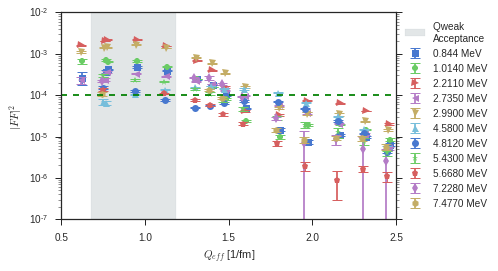

In [84]:
fig = pp.figure(figsize=plot_size)
pp.errorbar(al_0_8440_MeV_state_Q_eff, al_0_8440_MeV_state_ff, yerr=al_0_8440_MeV_state_err, ls='None', marker='s', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[0]))
pp.errorbar(al_1_0140_MeV_state_Q_eff, al_1_0140_MeV_state_ff, yerr=al_1_0140_MeV_state_err, ls='None', marker='8', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[1]))
pp.errorbar(al_2_2110_MeV_state_Q_eff, al_2_2110_MeV_state_ff, yerr=al_2_2110_MeV_state_err, ls='None', marker='>', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[2]))
pp.errorbar(al_2_7350_MeV_state_Q_eff, al_2_7350_MeV_state_ff, yerr=al_2_7350_MeV_state_err, ls='None', marker='<', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[3]))
pp.errorbar(al_2_9900_MeV_state_Q_eff, al_2_9900_MeV_state_ff, yerr=al_2_9900_MeV_state_err, ls='None', marker='v', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[4]))
pp.errorbar(al_4_5800_MeV_state_Q_eff, al_4_5800_MeV_state_ff, yerr=al_4_5800_MeV_state_err, ls='None', marker='^', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[10]))
pp.errorbar(al_4_8120_MeV_state_Q_eff, al_4_8120_MeV_state_ff, yerr=al_4_8120_MeV_state_err, ls='None', marker='o', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[11]))
pp.errorbar(al_5_4300_MeV_state_Q_eff, al_5_4300_MeV_state_ff, yerr=al_5_4300_MeV_state_err, ls='None', marker='*', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[14]))
pp.errorbar(al_5_6680_MeV_state_Q_eff, al_5_6680_MeV_state_ff, yerr=al_5_6680_MeV_state_err, ls='None', marker='p', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[17]))
pp.errorbar(al_7_2280_MeV_state_Q_eff, al_7_2280_MeV_state_ff, yerr=al_7_2280_MeV_state_err, ls='None', marker='d', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[27]))
pp.errorbar(al_7_4770_MeV_state_Q_eff, al_7_4770_MeV_state_ff, yerr=al_7_4770_MeV_state_err, ls='None', marker='h', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[30]))


#pp.errorbar(al_3_6800_MeV_state_Q_eff, al_3_6800_MeV_state_ff, yerr=al_3_6800_MeV_state_err, ls='None', marker='^', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[5]))
#pp.errorbar(al_3_9570_MeV_state_Q_eff, al_3_9570_MeV_state_ff, yerr=al_3_9570_MeV_state_err, ls='None', marker='o', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[6]))
#pp.errorbar(al_4_0550_MeV_state_Q_eff, al_4_0550_MeV_state_ff, yerr=al_4_0550_MeV_state_err, ls='None', marker='*', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[7]))
#pp.errorbar(al_4_4100_MeV_state_Q_eff, al_4_4100_MeV_state_ff, yerr=al_4_4100_MeV_state_err, ls='None', marker='p', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[8]))
#pp.errorbar(al_4_5100_MeV_state_Q_eff, al_4_5100_MeV_state_ff, yerr=al_4_5100_MeV_state_err, ls='None', marker='d', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[9]))
#pp.errorbar(al_5_1560_MeV_state_Q_eff, al_5_1560_MeV_state_ff, yerr=al_5_1560_MeV_state_err, ls='None', marker='H', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[12]))
#pp.errorbar(al_5_2480_MeV_state_Q_eff, al_5_2480_MeV_state_ff, yerr=al_5_2480_MeV_state_err, ls='None', marker='s', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[13]))
#pp.errorbar(al_5_5000_MeV_state_Q_eff, al_5_5000_MeV_state_ff, yerr=al_5_5000_MeV_state_err, ls='None', marker='>', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[15]))
#pp.errorbar(al_5_5510_MeV_state_Q_eff, al_5_5510_MeV_state_ff, yerr=al_5_5510_MeV_state_err, ls='None', marker='<', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[16]))
#pp.errorbar(al_5_8270_MeV_state_Q_eff, al_5_8270_MeV_state_ff, yerr=al_5_8270_MeV_state_err, ls='None', marker='^', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[18]))
#pp.errorbar(al_5_9600_MeV_state_Q_eff, al_5_9600_MeV_state_ff, yerr=al_5_9600_MeV_state_err, ls='None', marker='o', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[19]))
#pp.errorbar(al_6_1600_MeV_state_Q_eff, al_6_1600_MeV_state_ff, yerr=al_6_1600_MeV_state_err, ls='None', marker='*', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[20]))
#pp.errorbar(al_6_4770_MeV_state_Q_eff, al_6_4770_MeV_state_ff, yerr=al_6_4770_MeV_state_err, ls='None', marker='p', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[21]))
#pp.errorbar(al_6_5200_MeV_state_Q_eff, al_6_5200_MeV_state_ff, yerr=al_6_5200_MeV_state_err, ls='None', marker='d', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[22]))
#pp.errorbar(al_6_6050_MeV_state_Q_eff, al_6_6050_MeV_state_ff, yerr=al_6_6050_MeV_state_err, ls='None', marker='D', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[23]))
#pp.errorbar(al_6_6515_MeV_state_Q_eff, al_6_6515_MeV_state_ff, yerr=al_6_6515_MeV_state_err, ls='None', marker='h', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[24]))
#pp.errorbar(al_6_7100_MeV_state_Q_eff, al_6_7100_MeV_state_ff, yerr=al_6_7100_MeV_state_err, ls='None', marker='H', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[25]))
#pp.errorbar(al_6_9480_MeV_state_Q_eff, al_6_9480_MeV_state_ff, yerr=al_6_9480_MeV_state_err, ls='None', marker='s', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[26]))
#pp.errorbar(al_7_2900_MeV_state_Q_eff, al_7_2900_MeV_state_ff, yerr=al_7_2900_MeV_state_err, ls='None', marker='>', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[28]))
#pp.errorbar(al_7_4100_MeV_state_Q_eff, al_7_4100_MeV_state_ff, yerr=al_7_4100_MeV_state_err, ls='None', marker='<', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[29]))
#pp.errorbar(al_7_5800_MeV_state_Q_eff, al_7_5800_MeV_state_ff, yerr=al_7_5800_MeV_state_err, ls='None', marker='^', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[31]))
#pp.errorbar(al_7_6600_MeV_state_Q_eff, al_7_6600_MeV_state_ff, yerr=al_7_6600_MeV_state_err, ls='None', marker='o', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[32]))
#pp.errorbar(al_7_8000_MeV_state_Q_eff, al_7_8000_MeV_state_ff, yerr=al_7_8000_MeV_state_err, ls='None', marker='*', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[33]))
#pp.errorbar(al_8_4000_MeV_state_Q_eff, al_8_4000_MeV_state_ff, yerr=al_8_4000_MeV_state_err, ls='None', marker='p', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[34]))
#pp.errorbar(al_8_5200_MeV_state_Q_eff, al_8_5200_MeV_state_ff, yerr=al_8_5200_MeV_state_err, ls='None', marker='d', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[35]))
#pp.errorbar(al_8_8200_MeV_state_Q_eff, al_8_8200_MeV_state_ff, yerr=al_8_8200_MeV_state_err, ls='None', marker='D', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[36]))

#vert_low, vert_high = pp.ylim()
pp.fill_between(qweak_acceptance, y_low, y_high, 
                color=sns.xkcd_rgb['steel grey'], alpha=0.2, label='Qweak \nAcceptance')
pp.plot((x_low,x_high),(1e-4,1e-4), 'g--')
pp.yscale('log')
pp.ylim(y_low, y_high)
pp.xlabel('$Q_{eff}$ [1/fm]')
pp.ylabel('$|FF|^{2}$')
pp.tick_params(top=False)
pp.legend(bbox_to_anchor=(1.3,1.0), ncol=1)
#pp.legend(bbox_to_anchor=(1.30,1.0), ncol=2)
pp.savefig('plots/al_nuclear_excited_state_trunc_plot.pdf', bbox_inches='tight')
pp.savefig('plots/al_nuclear_excited_state_trunc_plot.png', bbox_inches='tight')
#pp.show()

Constant: 4.784e-04 +- 1.971e-05 
    Mean: 0.9599766 +- 0.0192711 
    Sigma: 0.3071582 +- 0.0123135 
    Chi**2: 29.938 
    DOF: 8 
    RChi**2: 3.742


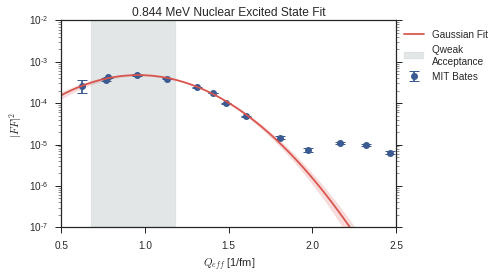

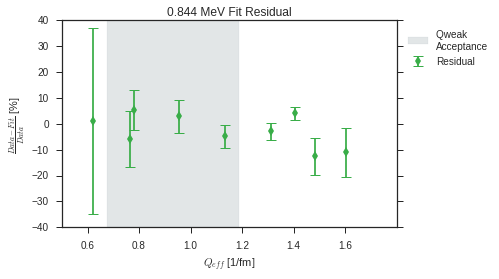

In [143]:
# 0.844 MeV Excited State Plots
plot_combo(al_0_8440_MeV_state_Q_eff, 
           al_0_8440_MeV_state_Q_eff_fit, 
           al_0_8440_MeV_state_ff, 
           al_0_8440_MeV_state_ff_fit, 
           al_0_8440_MeV_state_err, 
           al_0_8440_MeV_state_err_fit, 
           al_0_8440_MeV_popt, 
           al_0_8440_MeV_pcov, 
           al_0_8440_MeV_chi2, 
           energy_lvl[0])

Constant: 7.193e-04 +- 3.778e-05 
    Mean: 0.9049046 +- 0.0233719 
    Sigma: 0.2814528 +- 0.0133788 
    Chi**2: 66.610 
    DOF: 8 
    RChi**2: 8.326


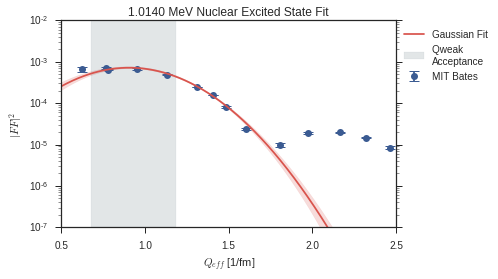

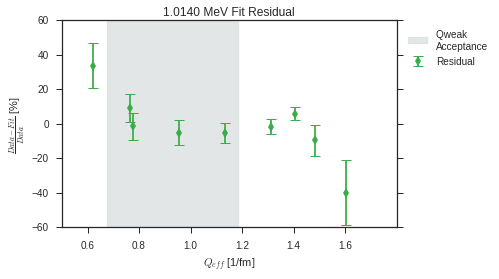

In [144]:
# 1.014 MeV Excited State Plots
plot_combo(al_1_0140_MeV_state_Q_eff, 
           al_1_0140_MeV_state_Q_eff_fit, 
           al_1_0140_MeV_state_ff, 
           al_1_0140_MeV_state_ff_fit, 
           al_1_0140_MeV_state_err, 
           al_1_0140_MeV_state_err_fit, 
           al_1_0140_MeV_popt, 
           al_1_0140_MeV_pcov, 
           al_1_0140_MeV_chi2,
           energy_lvl[1])

Constant: 2.351e-03 +- 6.105e-05 
    Mean: 0.8889833 +- 0.0104884 
    Sigma: 0.2650773 +- 0.0058775 
    Chi**2: 311.628 
    DOF: 20 
    RChi**2: 15.581


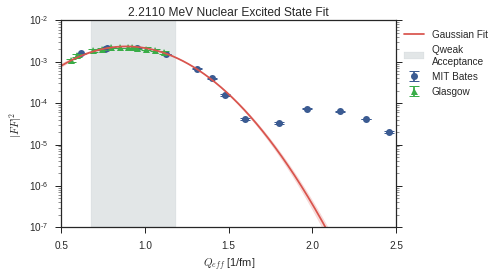

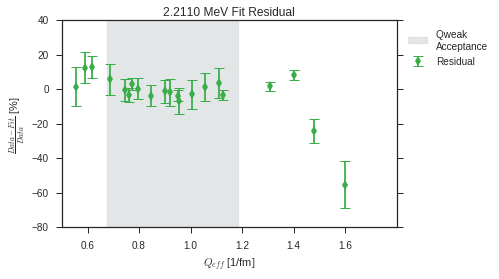

In [40]:
# 2.2110 MeV Excited State Plots
plot_combo_plus(al_2_2110_MeV_state_Q_eff, 
           al_2_2110_MeV_state_Q_eff_fit_mod, 
           al_2_2110_MeV_state_ff, 
           al_2_2110_MeV_state_ff_fit_mod, 
           al_2_2110_MeV_state_err, 
           al_2_2110_MeV_state_err_fit_mod,
           Singhal_2_210_MeV_state.Q_eff,
           Singhal_2_210_MeV_state.F_in_squared,
           Singhal_2_210_MeV_state.F_in_squared_err,
           al_2_2110_MeV_popt, 
           al_2_2110_MeV_pcov, 
           al_2_2110_MeV_chi2,
           energy_lvl[2])

Constant: 3.183e-04 +- 8.182e-06 
    Mean: 0.9614569 +- 0.0237207 
    Sigma: 0.4138585 +- 0.0194921 
    Chi**2: 53.736 
    DOF: 20 
    RChi**2: 2.687


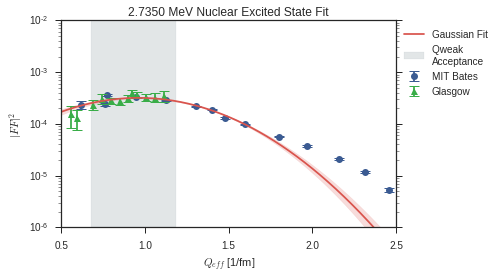

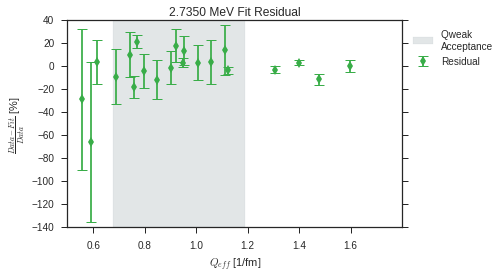

In [47]:
# 2.7350 MeV Excited State Plots
plot_combo_plus(al_2_7350_MeV_state_Q_eff, 
           al_2_7350_MeV_state_Q_eff_fit_mod, 
           al_2_7350_MeV_state_ff, 
           al_2_7350_MeV_state_ff_fit_mod, 
           al_2_7350_MeV_state_err, 
           al_2_7350_MeV_state_err_fit_mod, 
                Singhal_2_734_MeV_state.Q_eff,
                Singhal_2_734_MeV_state.F_in_squared,
                Singhal_2_734_MeV_state.F_in_squared_err,
           al_2_7350_MeV_popt, 
           al_2_7350_MeV_pcov, 
           al_2_7350_MeV_chi2,
           energy_lvl[3])

Constant: 1.657e-03 +- 2.742e-05 
    Mean: 0.9415276 +- 0.0077047 
    Sigma: 0.3115252 +- 0.0056671 
    Chi**2: 93.437 
    DOF: 21 
    RChi**2: 4.449


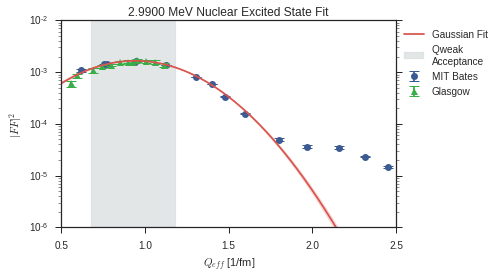

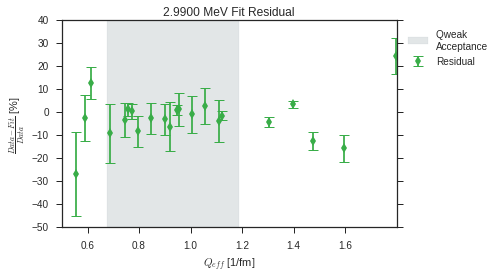

In [48]:
# 2.9900 MeV Excited State Plots
plot_combo_plus(al_2_9900_MeV_state_Q_eff, 
           al_2_9900_MeV_state_Q_eff_fit_mod, 
           al_2_9900_MeV_state_ff, 
           al_2_9900_MeV_state_ff_fit_mod, 
           al_2_9900_MeV_state_err, 
           al_2_9900_MeV_state_err_fit_mod, 
                Singhal_3_000_MeV_state.Q_eff,
                Singhal_3_000_MeV_state.F_in_squared,
                Singhal_3_000_MeV_state.F_in_squared_err,
           al_2_9900_MeV_popt, 
           al_2_9900_MeV_pcov, 
           al_2_9900_MeV_chi2,
           energy_lvl[4])

Constant: 1.593e-04 +- 3.117e-06 
    Mean: 1.3895749 +- 0.0156153 
    Sigma: 0.4825382 +- 0.0240437 
    Chi**2: 14.055 
    DOF: 8 
    RChi**2: 1.757


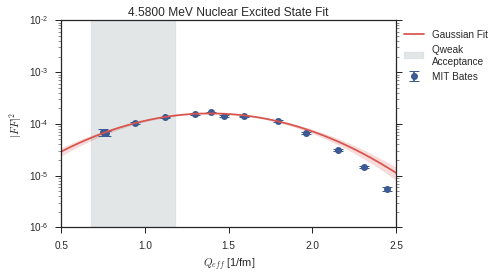

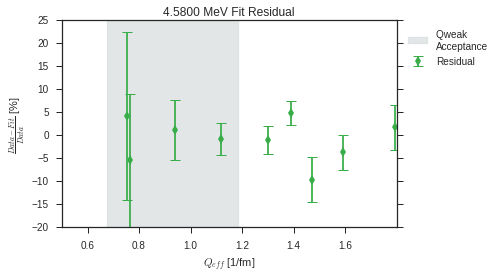

In [49]:
# 4.5800 MeV Excited State Plots
plot_combo(al_4_5800_MeV_state_Q_eff, 
           al_4_5800_MeV_state_Q_eff_fit, 
           al_4_5800_MeV_state_ff, 
           al_4_5800_MeV_state_ff_fit, 
           al_4_5800_MeV_state_err, 
           al_4_5800_MeV_state_err_fit, 
           al_4_5800_MeV_popt, 
           al_4_5800_MeV_pcov, 
           al_4_5800_MeV_chi2,
           energy_lvl[10])

Constant: 1.518e-04 +- inf 
    Mean: 0.7436539 +- inf 
    Sigma: -0.3207703 +- inf 
    Chi**2: 0.000 
    DOF: 2 
    RChi**2: 0.000


/usr/lib/python3.5/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in add


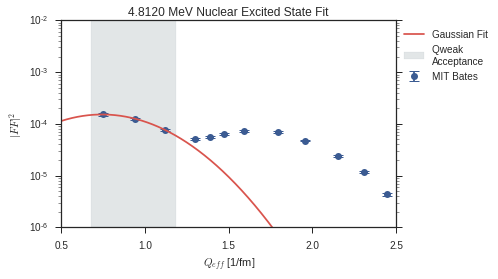

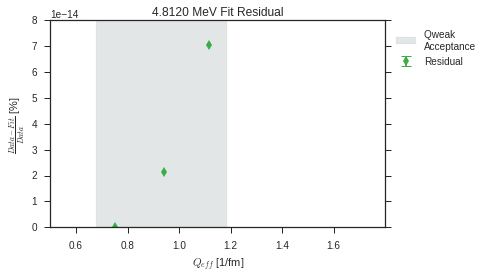

In [50]:
# 4.8120 MeV Excited State Plots
plot_combo(al_4_8120_MeV_state_Q_eff, 
           al_4_8120_MeV_state_Q_eff_fit, 
           al_4_8120_MeV_state_ff, 
           al_4_8120_MeV_state_ff_fit, 
           al_4_8120_MeV_state_err, 
           al_4_8120_MeV_state_err_fit, 
           al_4_8120_MeV_popt, 
           al_4_8120_MeV_pcov, 
           al_4_8120_MeV_chi2,
           energy_lvl[11])

Constant: 2.687e-04 +- 2.899e-05 
    Mean: 0.7792557 +- 0.1042354 
    Sigma: 0.4465656 +- 0.0504332 
    Chi**2: 14.418 
    DOF: 7 
    RChi**2: 2.060


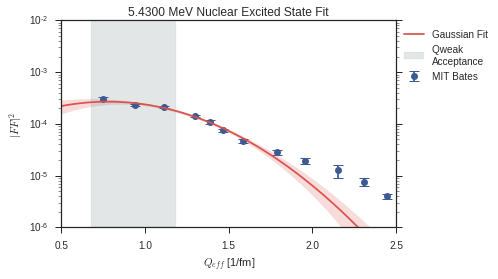

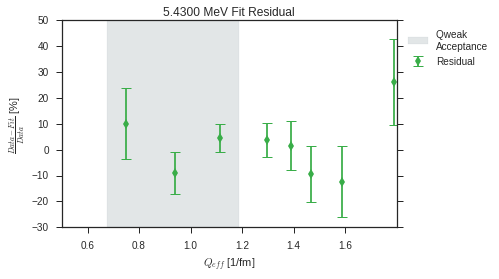

In [51]:
# 5.4300 MeV Excited State Plots
plot_combo(al_5_4300_MeV_state_Q_eff, 
           al_5_4300_MeV_state_Q_eff_fit, 
           al_5_4300_MeV_state_ff, 
           al_5_4300_MeV_state_ff_fit, 
           al_5_4300_MeV_state_err, 
           al_5_4300_MeV_state_err_fit, 
           al_5_4300_MeV_popt, 
           al_5_4300_MeV_pcov, 
           al_5_4300_MeV_chi2,
           energy_lvl[14])

Constant: 1.375e-04 +- 1.025e-05 
    Mean: 0.8912329 +- 0.0485835 
    Sigma: -0.3635918 +- 0.0232647 
    Chi**2: 10.118 
    DOF: 6 
    RChi**2: 1.686


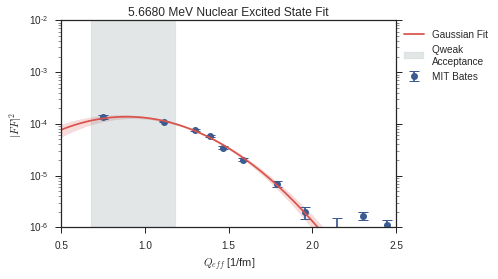

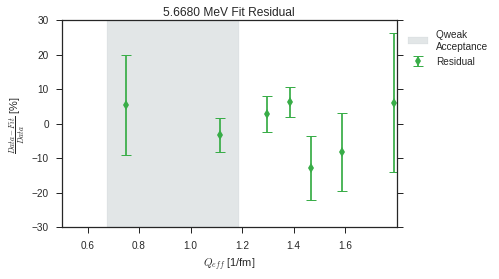

In [52]:
# 5.6680 MeV Excited State Plots
plot_combo(al_5_6680_MeV_state_Q_eff, 
           al_5_6680_MeV_state_Q_eff_fit, 
           al_5_6680_MeV_state_ff, 
           al_5_6680_MeV_state_ff_fit, 
           al_5_6680_MeV_state_err, 
           al_5_6680_MeV_state_err_fit, 
           al_5_6680_MeV_popt, 
           al_5_6680_MeV_pcov, 
           al_5_6680_MeV_chi2,
           energy_lvl[17])

Constant: 3.562e-04 +- 2.593e-05 
    Mean: 1.0591602 +- 0.0273296 
    Sigma: -0.3218205 +- 0.0159808 
    Chi**2: 19.346 
    DOF: 5 
    RChi**2: 3.869


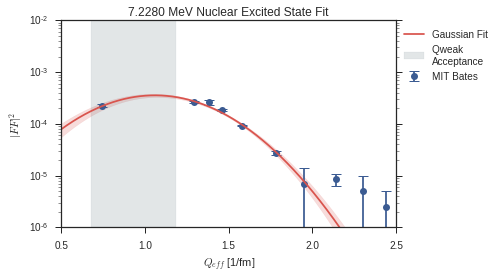

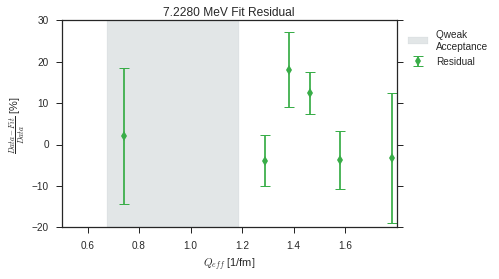

In [53]:
# 7.2280 MeV Excited State Plots
plot_combo(al_7_2280_MeV_state_Q_eff, 
           al_7_2280_MeV_state_Q_eff_fit, 
           al_7_2280_MeV_state_ff, 
           al_7_2280_MeV_state_ff_fit, 
           al_7_2280_MeV_state_err, 
           al_7_2280_MeV_state_err_fit, 
           al_7_2280_MeV_popt, 
           al_7_2280_MeV_pcov, 
           al_7_2280_MeV_chi2, 
           energy_lvl[27])

Constant: 2.102e-04 +- 3.305e-05 
    Mean: 1.0784616 +- 0.0419452 
    Sigma: -0.2994193 +- 0.0269216 
    Chi**2: 7.327 
    DOF: 3 
    RChi**2: 2.442


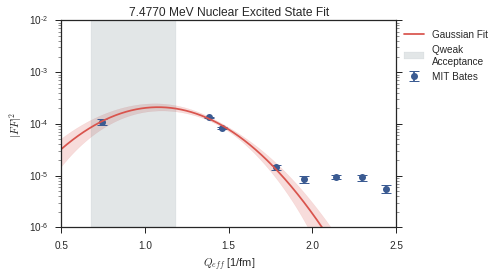

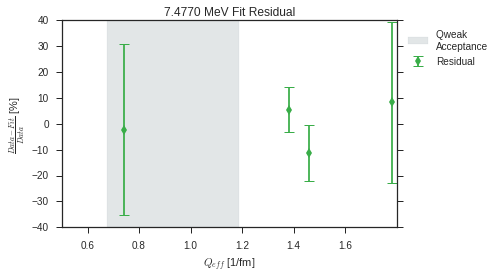

In [54]:
# 7.4770 MeV Excited State Plots
plot_combo(al_7_4770_MeV_state_Q_eff, 
           al_7_4770_MeV_state_Q_eff_fit, 
           al_7_4770_MeV_state_ff, 
           al_7_4770_MeV_state_ff_fit, 
           al_7_4770_MeV_state_err, 
           al_7_4770_MeV_state_err_fit, 
           al_7_4770_MeV_popt, 
           al_7_4770_MeV_pcov, 
           al_7_4770_MeV_chi2,
           energy_lvl[30])

In [55]:
rupesh_fit_values = pd.read_csv('data/rupesh_inelasticSPS_fit_values.dat')

In [56]:
rupesh_fit_values[:]

,energy,fconstant,fmean,fsigma
0,0.844,0.000427,0.958792,0.341168
1,1.016,0.000706,0.868077,0.350506
2,2.211,0.002337,0.857955,0.290595
3,2.735,0.000306,0.955732,0.379688
4,2.990,0.001598,0.948107,0.330035
5,3.680,0.000042,0.992771,0.395955
6,4.510,0.000135,1.340052,0.302506
7,4.580,0.000162,1.297271,0.352787


In [57]:
mit_bates_fit_energy = np.array((energy_lvl[0], 
                        energy_lvl[1], 
                        energy_lvl[2], 
                        energy_lvl[3], 
                        energy_lvl[4], 
                        energy_lvl[10], 
                        #energy_lvl[11], 
                        energy_lvl[14], 
                        energy_lvl[17], 
                        energy_lvl[27], 
                        energy_lvl[30]))
mit_bates_fit_constant = np.array((al_0_8440_MeV_popt[0], 
                          al_1_0140_MeV_popt[0], 
                          al_2_2110_MeV_popt[0], 
                          al_2_7350_MeV_popt[0], 
                          al_2_9900_MeV_popt[0], 
                          al_4_5800_MeV_popt[0], 
                          #al_4_8120_MeV_popt[0], 
                          al_5_4300_MeV_popt[0], 
                          al_5_6680_MeV_popt[0], 
                          al_7_2280_MeV_popt[0], 
                          al_7_4770_MeV_popt[0]))
mit_bates_fit_constant_err = np.sqrt((al_0_8440_MeV_pcov[0,0], 
                              al_1_0140_MeV_pcov[0,0], 
                              al_2_2110_MeV_pcov[0,0], 
                              al_2_7350_MeV_pcov[0,0], 
                              al_2_9900_MeV_pcov[0,0], 
                              al_4_5800_MeV_pcov[0,0], 
                              #al_4_8120_MeV_pcov[0,0], 
                              al_5_4300_MeV_pcov[0,0], 
                              al_5_6680_MeV_pcov[0,0], 
                              al_7_2280_MeV_pcov[0,0], 
                              al_7_4770_MeV_pcov[0,0]))
mit_bates_fit_mean = np.array((al_0_8440_MeV_popt[1], 
                      al_1_0140_MeV_popt[1], 
                      al_2_2110_MeV_popt[1], 
                      al_2_7350_MeV_popt[1], 
                      al_2_9900_MeV_popt[1], 
                      al_4_5800_MeV_popt[1], 
                      #al_4_8120_MeV_popt[1], 
                      al_5_4300_MeV_popt[1], 
                      al_5_6680_MeV_popt[1], 
                      al_7_2280_MeV_popt[1], 
                      al_7_4770_MeV_popt[1]))
mit_bates_fit_mean_err = np.sqrt((al_0_8440_MeV_pcov[1,1], 
                          al_1_0140_MeV_pcov[1,1], 
                          al_2_2110_MeV_pcov[1,1], 
                          al_2_7350_MeV_pcov[1,1], 
                          al_2_9900_MeV_pcov[1,1], 
                          al_4_5800_MeV_pcov[1,1], 
                          #al_4_8120_MeV_pcov[1,1], 
                          al_5_4300_MeV_pcov[1,1], 
                          al_5_6680_MeV_pcov[1,1],
                          al_7_2280_MeV_pcov[1,1], 
                          al_7_4770_MeV_pcov[1,1]))
mit_bates_fit_sigma = np.array((al_0_8440_MeV_popt[2], 
                                al_1_0140_MeV_popt[2], 
                       al_2_2110_MeV_popt[2], 
                       al_2_7350_MeV_popt[2], 
                       al_2_9900_MeV_popt[2], 
                       al_4_5800_MeV_popt[2], 
                       #al_4_8120_MeV_popt[2], 
                       al_5_4300_MeV_popt[2], 
                       al_5_6680_MeV_popt[2], 
                       al_7_2280_MeV_popt[2], 
                       al_7_4770_MeV_popt[2]))
mit_bates_fit_sigma_err = np.sqrt((al_0_8440_MeV_pcov[2,2], 
                           al_1_0140_MeV_pcov[2,2], 
                           al_2_2110_MeV_pcov[2,2], 
                           al_2_7350_MeV_pcov[2,2], 
                           al_2_9900_MeV_pcov[2,2], 
                           al_4_5800_MeV_pcov[2,2], 
                           #al_4_8120_MeV_pcov[2,2], 
                           al_5_4300_MeV_pcov[2,2], 
                           al_5_6680_MeV_pcov[2,2], 
                           al_7_2280_MeV_pcov[2,2], 
                           al_7_4770_MeV_pcov[2,2]))
mit_bates_fit_chi2 = np.array((al_0_8440_MeV_chi2, 
                               al_1_0140_MeV_chi2, 
                               al_2_2110_MeV_chi2, 
                               al_2_7350_MeV_chi2, 
                               al_2_9900_MeV_chi2, 
                               al_4_5800_MeV_chi2, 
                               #al_4_8120_MeV_chi2, 
                               al_5_4300_MeV_chi2, 
                               al_5_6680_MeV_chi2, 
                               al_7_2280_MeV_chi2, 
                               al_7_4770_MeV_chi2))
fit_parameters = {'energy': mit_bates_fit_energy,
                  'const' : mit_bates_fit_constant, 
                  'const_err': mit_bates_fit_constant_err,
                  'mean' : mit_bates_fit_mean, 
                  'mean_err' : mit_bates_fit_mean_err, 
                  'sigma' : mit_bates_fit_sigma, 
                  'sigma_err': mit_bates_fit_sigma_err, 
                  'chi2' : mit_bates_fit_chi2}
fit_parameters_frame = pd.DataFrame(fit_parameters, columns=['energy','const','const_err','mean','mean_err','sigma','sigma_err','chi2'])
fit_parameters_frame.to_csv('data/al_nuclear_excited_state_fit_parameters.csv', index=False)

In [58]:
fit_parameters_frame[:]

,energy,const,const_err,mean,mean_err,sigma,sigma_err,chi2
0,0.844,0.000478,0.000020,0.959977,0.019271,0.307158,0.012313,29.937708
1,1.0140,0.000719,0.000038,0.904905,0.023372,0.281453,0.013379,66.609572
2,2.2110,0.002351,0.000061,0.888983,0.010488,0.265077,0.005878,311.628322
3,2.7350,0.000318,0.000008,0.961457,0.023721,0.413858,0.019492,53.735564
4,2.9900,0.001657,0.000027,0.941528,0.007705,0.311525,0.005667,93.437040
5,4.5800,0.000159,0.000003,1.389575,0.015615,0.482538,0.024044,14.054945
6,5.4300,0.000269,0.000029,0.779256,0.104235,0.446566,0.050433,14.417638
7,5.6680,0.000137,0.000010,0.891233,0.048583,-0.363592,0.023265,10.117905
8,7.2280,0.000356,0.000026,1.059160,0.027330,-0.321820,0.015981,19.346473
9,7.4770,0.000210,0.000033,1.078462,0.041945,-0.299419,0.026922,7.326825


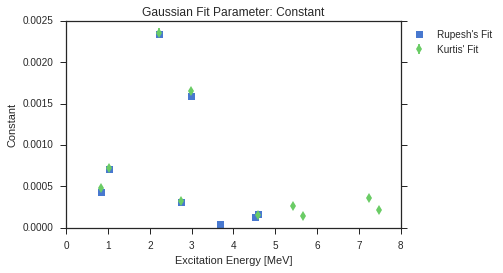

In [59]:
pp.figure(figsize=plot_size)
pp.plot(rupesh_fit_values.energy, rupesh_fit_values.fconstant, ls='None', marker='s', label="Rupesh's Fit")
pp.errorbar(mit_bates_fit_energy, mit_bates_fit_constant, yerr=mit_bates_fit_constant_err, ls='None', marker='d', label="Kurtis' Fit")
pp.title('Gaussian Fit Parameter: Constant')
pp.xlabel('Excitation Energy [MeV]')
pp.ylabel('Constant')
pp.legend(bbox_to_anchor=(1.30, 1.0))
pp.tick_params(top=False)
pp.savefig('plots/excited_state_fit_parameter_constant.pdf', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_constant.png', bbox_inches='tight')
pp.show()

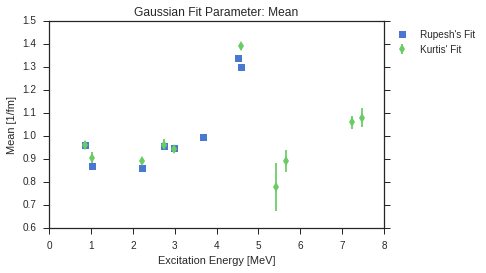

In [60]:
pp.figure(figsize=plot_size)
pp.plot(rupesh_fit_values.energy, rupesh_fit_values.fmean, ls='None', marker='s', label="Rupesh's Fit")
pp.errorbar(mit_bates_fit_energy, mit_bates_fit_mean, yerr=mit_bates_fit_mean_err, ls='None', marker='d', label="Kurtis' Fit")
pp.title('Gaussian Fit Parameter: Mean')
pp.xlabel('Excitation Energy [MeV]')
pp.ylabel('Mean [1/fm]')
pp.legend(bbox_to_anchor=(1.30, 1.0))
pp.tick_params(top=False)
pp.savefig('plots/excited_state_fit_parameter_mean.pdf', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_mean.png', bbox_inches='tight')
pp.show()

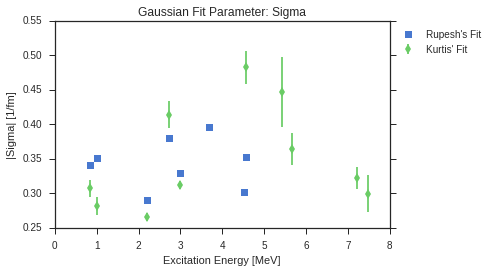

In [61]:
pp.figure(figsize=plot_size)
pp.plot(rupesh_fit_values.energy, rupesh_fit_values.fsigma, ls='None', marker='s', label="Rupesh's Fit")
pp.errorbar(mit_bates_fit_energy, np.absolute(mit_bates_fit_sigma), yerr=mit_bates_fit_sigma_err, ls='None', marker='d', label="Kurtis' Fit")
pp.title('Gaussian Fit Parameter: Sigma')
pp.xlabel('Excitation Energy [MeV]')
pp.ylabel('|Sigma| [1/fm]')
pp.legend(bbox_to_anchor=(1.30, 1.0))
pp.tick_params(top=False)
pp.savefig('plots/excited_state_fit_parameter_sigma.pdf', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_sigma.png', bbox_inches='tight')
pp.show()